In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import json
pd.set_option("display.precision", 1)

In [2]:
test_names = ["tabformer_t41", "tabformer_t42"]

### Step 1: Plot Training Log

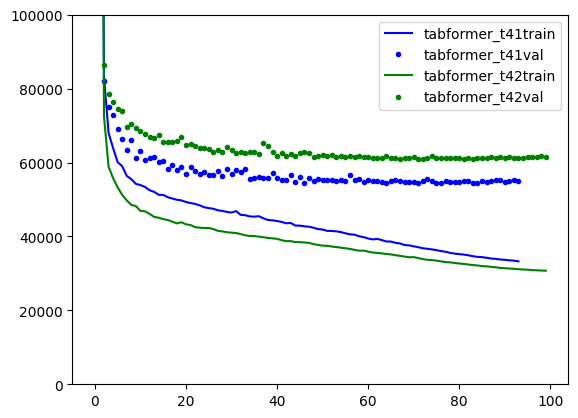

In [3]:
def read_log(log_file):
    data = []
    with open(log_file) as f:
        for line in f:
            data.append(json.loads(line))
    
    return pd.DataFrame.from_dict(data[:-1])
colors = ["b", "g", "r", "c", "m", "y", "k"]
log_files = ["../model_checkpoints/%s/log.txt"%(t) for t in test_names]
log_dfs = [read_log(f) for f in log_files]
for i in range(len(test_names)):
    plt.plot(log_dfs[i]["epoch"], log_dfs[i]["train_loss"], colors[i]+"-", label=test_names[i] + "train")
    plt.plot(log_dfs[i]["epoch"], log_dfs[i]["val_error"], colors[i]+".", label=test_names[i] + "val")
plt.ylim([0, 1e5])
plt.legend()

In [13]:
# xgb_df.head(3)

<BarContainer object of 25 artists>

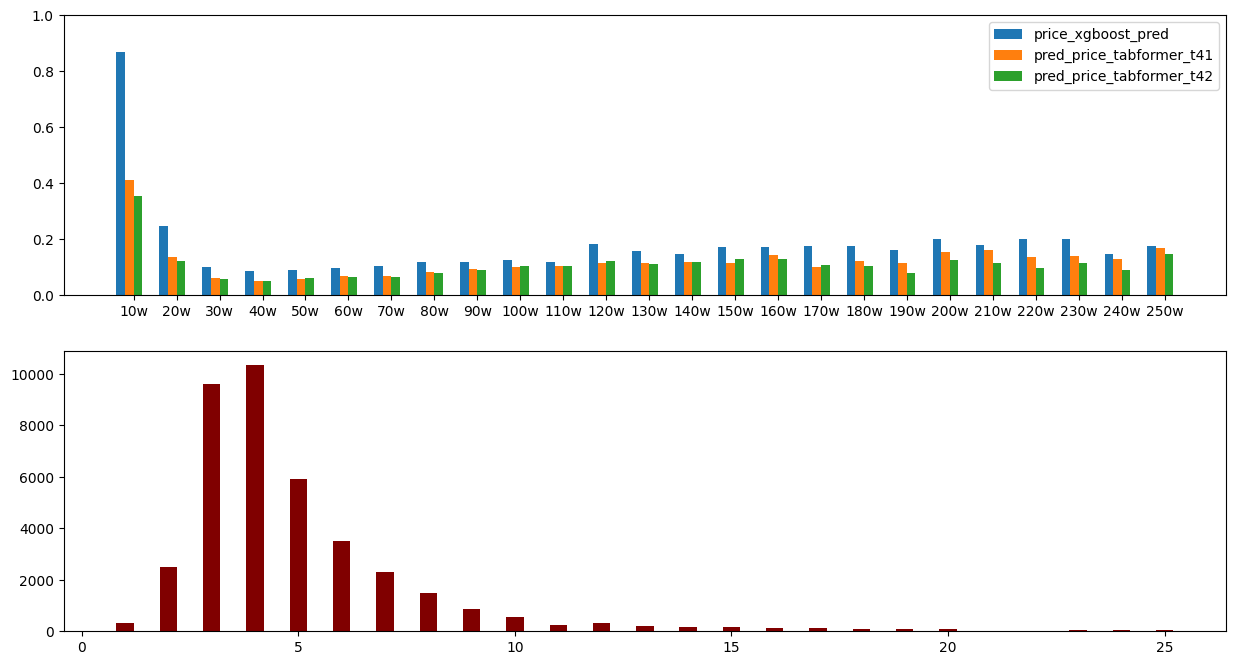

In [10]:
### Step 2: Barplot for the validation prediction 

val_pred_files = ["../model_checkpoints/%s/val_pred.pkl"%(t) for t in test_names]
val_pred_dfs = [pd.read_pickle(f) for f in val_pred_files]

xgb_df = pd.read_pickle("../data/val_xgboost_pred.pkl")
for df_, test_name in zip(val_pred_dfs, test_names):
    xgb_df["pred_price_" + test_name] = df_["pred"]
xgb_df["price"] = df_["true_price"]

display_names = ["price_xgboost_pred"] + ["pred_price_" + test_name for test_name in test_names] 

bin_stats, edges, binnumbers = [], [], []
for display_name in display_names:
    filter_index = xgb_df[display_name].notna()
    a, b, c, = binned_statistic(xgb_df.loc[filter_index, "price"], 
                              xgb_df.loc[filter_index].apply(lambda x: np.abs(x["price"] - x[display_name]) / x["price"], axis=1), 
                              statistic='median', 
                              bins=25, 
                              range=(0, 2.5e6)
         )
    bin_stats.append(a)
    edges.append(b)
    binnumbers.append(c)

bin_edges = edges[0]
binnumber = binnumbers[0]
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = np.array([(int(_/1e5) + 1) for _ in bin_edges[1:] - bin_width/2])
X = np.array([ "%i0w"%(int(_/1e5) + 1) for _ in bin_edges[1:] - bin_width/2])
cnt = Counter(binnumber)
bin_cnt = [cnt[int(i)] for i in bin_centers]

f, ax = plt.subplots(2, 1)
f.set_figheight(8)
f.set_figwidth(15)


offset_step = 0.6 / len(display_names)
offsets = [(i - len(display_names)/2)*offset_step for i in range(len(display_names))]


for i in range(len(display_names)):
    ax[0].bar(bin_centers + offsets[i], bin_stats[i], width = 0.2, label=display_names[i])

ax[0].set_ylim([0, 1])
ax[0].set_xticks(bin_centers, X) 
ax[0].legend()
ax[1].bar(bin_centers, bin_cnt, color ='maroon', 
        width = 0.4)

In [43]:
raw_df = pd.read_pickle("../data/property_structured_12162024.pkl").reset_index(drop=True)

In [46]:
join_df = xgb_df.join(raw_df.set_index("address_key").drop(["address", 'price'], axis=1), on="address", how="left")
join_df.head(3)

,address,price_xgboost_pred,price,pred_price_tabformer_t30,pred_price_tabformer_t32a,pred_price_tabformer_t32c,pred_price_tabformer_t32e,harlink,mp_features,agent,...,floor_type_multiclass,Exterior Type_multiclass,Exterior_multiclass,Style_multiclass,finance_option_multiclass,high_school_star,middle_school_star,elementary_school_star,school_org,general_desc
0,"18756 Laurel Hills Dr, New Caney, TX 77357",308187.8,304900.0,318907.7,318570.6,314105.1,308297.7,https://www.har.com//homedetail/18756-laurel-h...,"4 bedrooms 2,144 Sqft. ($142/Sqft.) 2 full bat...",Sandy Brabham Keller Williams Realty Nort...,...,"[carpet, tile]","[brick, cement board, stone]","[back yard fenced, covered patio/deck, sprinkl...",[traditional],"[cash sale, conventional, fha, va]",4.0,4.0,3.0,[NEW CANEY ISD],"Adorable single-story home in Tavola, a Master..."
1,"18719 Scopello Dr, New Caney, TX 77357",279425.2,272990.0,269811.5,267115.2,261700.2,285102.1,https://www.har.com//homedetail/18719-scopello...,"4 bedrooms 1,760 Sqft. ($155/Sqft.) 2 full bat...",Jared Turner Lennar Homes Village Builders...,...,[],"[brick, cement board]",[],[traditional],"[cash sale, conventional, fha, va]",4.0,4.0,4.0,[NEW CANEY ISD],"NEW! Lennar Homes Watermill Series, ""Oxford"" f..."
2,"22608 Hackberry Leaf Dr, New Caney, TX 77357",315488.8,325990.0,297899.8,302734.2,297646.7,322470.6,https://www.har.com//homedetail/22608-hackberr...,"4 bedrooms 2,289 Sqft. ($142/Sqft.) 2 full & 1...",Jared Turner Lennar Homes Village Builders...,...,[],[brick],[],[traditional],[],3.0,NaN,0.0,[SPLENDORA ISD],"NEW! Lennar Wildflower Collection ""LARKSPUR II..."


In [ ]:
## Test data

In [4]:
test_df = pd.read_pickle("../data/property_structured_test_1107_1216_2024_tabformer_t32c_inference.pkl")

In [5]:
test_df.head(5)

,address,address_key,model_pred,price
0,"336 Main Street, Bertram, TX 78605","336 Main Street, Bertram, TX 78605",396024.7,345000.0
1,"6020 Pitcher Way, Aubrey, TX 76227","6020 Pitcher Way, Aubrey, TX 76227",431225.7,353990.0
2,"2224 Littleleaf Lane, Leander, TX 78641","2224 Littleleaf Lane, Leander, TX 78641",600943.9,490000.0
3,"28609 Paradise Manor Drive, Marble Falls, TX 7...","28609 Paradise Manor Drive, Marble Falls, TX 7...",342588.0,399000.0
4,"161 E Water St, Milford, TX 76670","161 E Water St, Milford, TX 76670",336582.8,270000.0


In [9]:
test_df.apply(lambda x: np.abs(x["model_pred"] - x["price"]), axis=1).mean()

56514.42911356282

(0.0, 1000000.0)

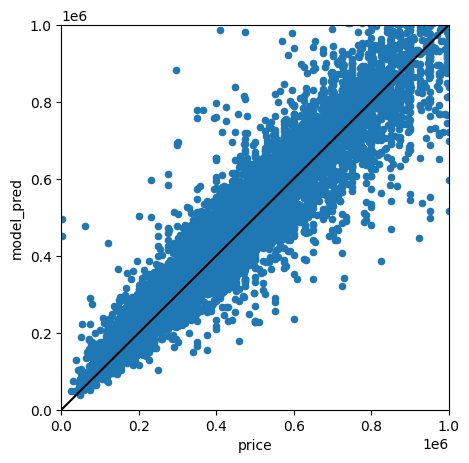

In [24]:
ax = test_df.plot.scatter(x="price", y="model_pred", figsize=(5, 5))
ax.plot([0, 1e6], [0, 1e6], "k-")
ax.set_xlim([0, 1e6])
ax.set_ylim([0, 1e6])

In [25]:
test_df[test_df.apply(lambda x: x["price"] < 4e5 and x["model_pred"] > 8e5, axis=1)]

,address,address_key,model_pred,price
2231,"14675 Kelly Rd, Forney, TX 75126","14675 Kelly Rd, Forney, TX 75126",883076.2,295000.0


In [5]:
tem_df = pd.read_pickle("../data/tem.pkl")

In [8]:
from tqdm import tqdm
import os
image_folder = "/home/user/DataCenter/HAR_data/house_images/"
all_folders = []
for i in tqdm(range(100)):
    for j in range(100):
        folder = os.path.join(image_folder, f"{i:04d}/{j:04d}") 
        all_folders.extend([os.path.join(folder, f) for f in os.listdir(folder)])
image_df = pd.DataFrame(all_folders, columns=["image_path"])
image_df["address"] = image_df["image_path"].apply(lambda x: x.split("/")[-1][:-11])
image_df["time_epoch"] = image_df["image_path"].apply(lambda x: x.split("/")[-1][-10:])
print(len(image_df))
image_df = image_df.sort_values("time_epoch").drop_duplicates("address", keep="last")
print(len(image_df))

print(len(tem_df))
join_df2 = tem_df.join(image_df.set_index("address")[["image_path"]], on="address", how="inner")
print(len(join_df2))
join_df2.head(2)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.84it/s]

608920
606158
509545
142351


,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space,address_key,date,json_path,time_epoch,image_path
92,"2620 Fallcreek Dr, Carrollton, TX 75006",https://www.har.com//homedetail/2620-fallcreek...,"4 Bed(s) 2 Full & 1 Half Bath(s) 2 Stories 2,1...","Compass RE Texas, LLC. WORK FOR Kim Gambino",349999.0,86.0,Under Contract - Pending,75006,4,2,1,2139,0,2,0,"2620 Fallcreek Dr, Carrollton, TX 75006",2020_10_31,/home/user/DataCenter/HAR_data/address_fullinf...,1719113786,/home/user/DataCenter/HAR_data/house_images/00...
5,"4646 Rhett Ln D, Carrollton, TX 75010",https://www.har.com//homedetail/4646-rhett-ln-...,"2 Bed(s) 2 Full & 1 Half Bath(s) 2 Stories 1,5...",RE/MAX ProAdvantage WORK FOR Carole Campbell,296500.0,72.0,Under Contract - Pending Continue to Show,75010,2,2,1,1533,0,2,0,"4646 Rhett Ln D, Carrollton, TX 75010",2020_10_31,/home/user/DataCenter/HAR_data/address_fullinf...,1598049740,/home/user/DataCenter/HAR_data/house_images/00...


In [13]:
join_df2["month"] = join_df2["date"].apply(lambda x: x[:-3])
join_df2.groupby("month").count()["address"]

month
2020_10       19
2020_11      524
2020_12      561
2021_01      423
2021_02      519
2021_03      763
2021_04      857
2021_05      999
2021_06      912
2021_07      904
2021_08      892
2021_09      846
2021_10      983
2021_11      528
2021_12      853
2022_01      677
2022_02      608
2022_03      898
2022_04      922
2022_05     1084
2022_06     1124
2022_07     1754
2023_04    15789
2023_05    18309
2023_06    18453
2023_07    20461
2023_08    17783
2023_09    17022
2023_10    14589
2023_11     2295
Name: address, dtype: int64